# Part 2: design a penalty function that enhances discrimination in the latent space.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060 Ti


## Load the dataset

In [2]:
# From pytorch dataset
kmnist_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1918,), (0.3483))]) ### 0.1918 and 0.3483 is the mean and standard deviation of the dataset in tensor format

train_dataset = datasets.KMNIST(root='./data', train=True, transform=kmnist_transform, download=True)
test_dataset = datasets.KMNIST(root='./data', train=False, transform=kmnist_transform, download=True) ### Set download to False if you have dataset

In [43]:
# Create test loader for data visualization
test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset),
                         num_workers=2,
                         shuffle=True)

whole_train_loader = DataLoader(train_dataset,
                                batch_size=100,
                                num_workers=2)

In [4]:
# Split train dataset for validation (10000 for validation, 50000 for training)
num_train = len(train_dataset)
indices = list(range(num_train))
val_size = 10000

val_idx = np.random.choice(indices, size=val_size, replace=False)
train_idx = list(set(indices) - set(val_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

## Autoencoder design

In [5]:
# Same as part 1
class Encoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(784, 800) ### 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, bottleneck_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    
# Decoder
class Decoder(nn.Module):
    
    def __init__(self, bottleneck_size):
        '''
        bottleneck_size: dimension of features we encode
        '''
        super(Decoder, self).__init__()
        self.encode_dim = bottleneck_size
        # Hidden layer
        self.fc1 = nn.Linear(bottleneck_size, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800, 784)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [6]:
# Combine encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## Define neccessary funtion

In [7]:
# Define cauchy_schwarz_divergence
def get_potential(X, Y, batch_size):
    sub = torch.sum((X - Y)**2, axis=-1)
    G = torch.exp(-sub / (2 * batch_size)) / np.sqrt(2 * np.pi * batch_size)
    return G

def cauchy_schwarz_divergence(latent, mean, std, batch_size):
    # mean and std are for the Gaussian prior
    prior = torch.normal(mean, std, size=latent.size()).to(latent.device)
    #  Renyi’s Entropy estimate
    vx = get_potential(latent, latent, batch_size)
    vy = get_potential(prior, prior, batch_size)
    vxy = get_potential(latent, prior, batch_size)
    # Calculate the Cauchy-Schwarz divergence 
    csd = torch.log(torch.sqrt(torch.mean(vx)*torch.mean(vy)) / torch.mean(vxy))

    return csd

In [8]:
# Define 3D visualization of latent space
def latent_3d_plot(encoder, name, test_loader = test_loader, download=True):
    idx, (img, target) = next(enumerate(test_loader))
    img = img.to(device)
    with torch.no_grad():
        target = target.to(device).cpu().numpy()

        bottleneck = encoder(img).cpu().numpy()
        # Create a 3D subplot

        fig = plt.figure(figsize=(5, 10))
        ax = fig.add_subplot(111, projection='3d')
        x = bottleneck[:, 0]
        y = bottleneck[:, 1]
        z = bottleneck[:, 2]
        ax.set_title(name)
        # Scatter plot
        ax.scatter(x, y, z, c=target, cmap=plt.cm.gist_rainbow, label=target, s=10)
    if download:
        plt.savefig('./figure/{}.png'.format(name))

In [88]:
# Define training function
def train_epoch(ae, device, train_loader, criterion, optimizer, lamb, batch_size, divergence=None):
    ae.train()
    train_loss = 0.0
    train_step = len(train_loader)
    for idx, (img, _) in enumerate(train_loader):  
        # Forward pass
        img = img.to(device)
        output = ae(img)
        reconstruction_loss = criterion(output, img)
        
        if divergence:
            # ITL regularization using Cauchy-Schwarz divergence
            bottleneck = ae.encoder(img)
            itl_loss = divergence(bottleneck, 0, 1, batch_size)  ### Use Normal Gaussian distribution
            # Combine losses
            loss = reconstruction_loss + lamb * itl_loss
        else:
            loss = reconstruction_loss
        train_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return train_loss / train_step


def ae_training(ae, device, train_dataset, criterion, optimizer, epochs, lamb, batch_size, divergence, printer=True, visualization=True):
    ae = ae.to(device)
    train_lc = []
    # Create train_loader
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=2)

    if printer:
        print('================================================================')
    for epoch in range(epochs):
        start = time.time()
        # Train in one epoch
        train_loss = train_epoch(ae, device, train_loader, criterion, optimizer, lamb=lamb, batch_size=batch_size, divergence=divergence)
        end = time.time()
        train_lc.append(train_loss)
        if printer:
            print('Epoch {}/{} (time usage: {:.4f}s):'.format(epoch+1, epochs, end - start))
            print('Train_Loss: {:.6f}'.format(train_loss))
            print('================================================================')
    
    if visualization:
        plt.figure(figsize=(7, 5))
        plt.plot(train_lc, label='train loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()
        
    return train_lc

## Hyperparameters tuning

Epoch 1/60 (time usage: 7.3836s):
Train_Loss: 0.637922
Epoch 2/60 (time usage: 7.5242s):
Train_Loss: 0.596295
Epoch 3/60 (time usage: 7.4170s):
Train_Loss: 0.582003
Epoch 4/60 (time usage: 7.5481s):
Train_Loss: 0.572317
Epoch 5/60 (time usage: 7.3767s):
Train_Loss: 0.565063
Epoch 6/60 (time usage: 7.3240s):
Train_Loss: 0.559140
Epoch 7/60 (time usage: 7.4149s):
Train_Loss: 0.554101
Epoch 8/60 (time usage: 7.3880s):
Train_Loss: 0.549847
Epoch 9/60 (time usage: 7.3799s):
Train_Loss: 0.546187
Epoch 10/60 (time usage: 7.3795s):
Train_Loss: 0.543098
Epoch 11/60 (time usage: 7.1008s):
Train_Loss: 0.540426
Epoch 12/60 (time usage: 7.2773s):
Train_Loss: 0.537689
Epoch 13/60 (time usage: 7.2522s):
Train_Loss: 0.535143
Epoch 14/60 (time usage: 7.2511s):
Train_Loss: 0.533311
Epoch 15/60 (time usage: 7.2559s):
Train_Loss: 0.531140
Epoch 16/60 (time usage: 7.3038s):
Train_Loss: 0.529414
Epoch 17/60 (time usage: 7.4907s):
Train_Loss: 0.527606
Epoch 18/60 (time usage: 7.4275s):
Train_Loss: 0.525886
E

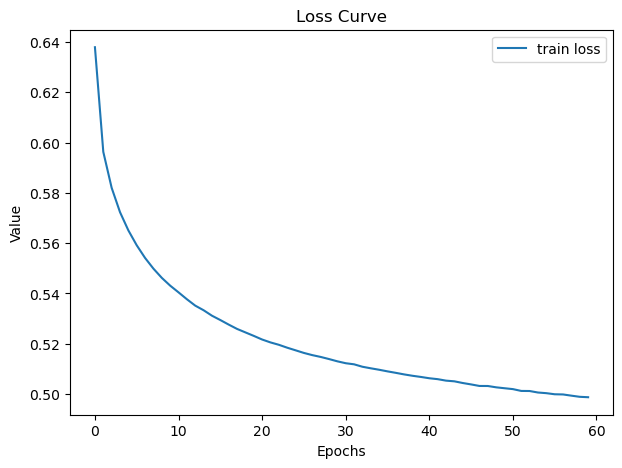

In [10]:
# Without Regularization
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=None)

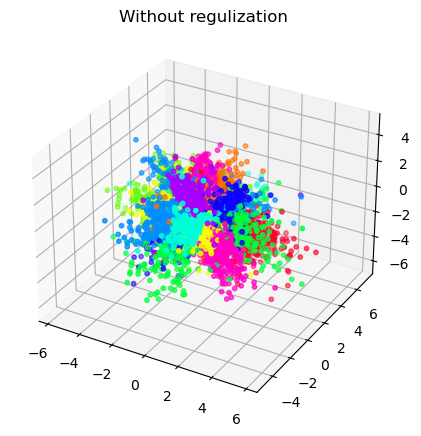

In [11]:
latent_3d_plot(encoder=ae.encoder, name='Without regulization')

### Experiment with &lambda;

Epoch 1/50 (time usage: 7.6721s):
Train_Loss: 0.637922
Epoch 2/50 (time usage: 7.7048s):
Train_Loss: 0.596295
Epoch 3/50 (time usage: 7.4506s):
Train_Loss: 0.582003
Epoch 4/50 (time usage: 7.6134s):
Train_Loss: 0.572317
Epoch 5/50 (time usage: 7.4142s):
Train_Loss: 0.565063
Epoch 6/50 (time usage: 7.6614s):
Train_Loss: 0.559140
Epoch 7/50 (time usage: 7.6494s):
Train_Loss: 0.554101
Epoch 8/50 (time usage: 7.6666s):
Train_Loss: 0.549847
Epoch 9/50 (time usage: 7.7654s):
Train_Loss: 0.546187
Epoch 10/50 (time usage: 7.3655s):
Train_Loss: 0.543098
Epoch 11/50 (time usage: 7.4069s):
Train_Loss: 0.540426
Epoch 12/50 (time usage: 7.5205s):
Train_Loss: 0.537689
Epoch 13/50 (time usage: 7.6800s):
Train_Loss: 0.535143
Epoch 14/50 (time usage: 7.5796s):
Train_Loss: 0.533311
Epoch 15/50 (time usage: 7.4324s):
Train_Loss: 0.531140
Epoch 16/50 (time usage: 7.5184s):
Train_Loss: 0.529414
Epoch 17/50 (time usage: 7.5826s):
Train_Loss: 0.527606
Epoch 18/50 (time usage: 7.5411s):
Train_Loss: 0.525886
E

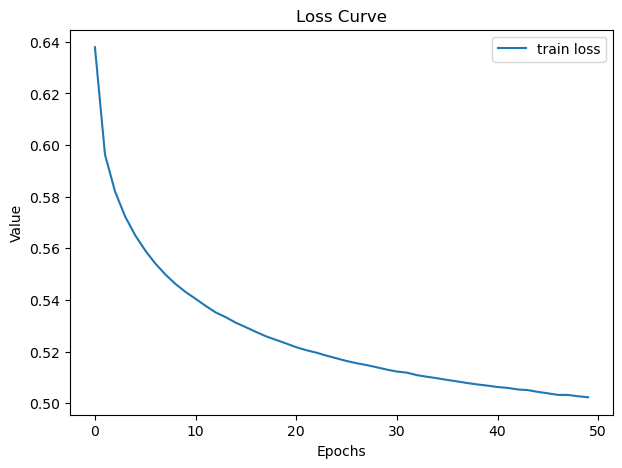

In [12]:
# lambda = 0.1, fixed batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.0
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence)

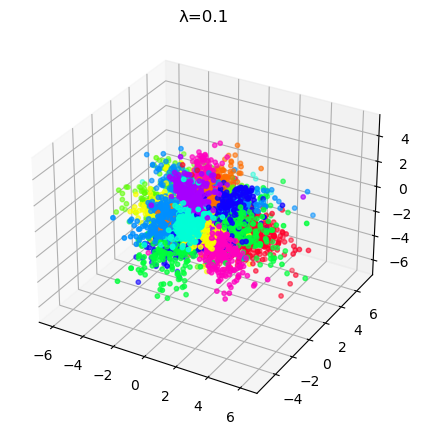

In [13]:
latent_3d_plot(encoder=ae.encoder, name='λ=0.1')

In [14]:
# lambda = 0.01, fixed batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.01
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

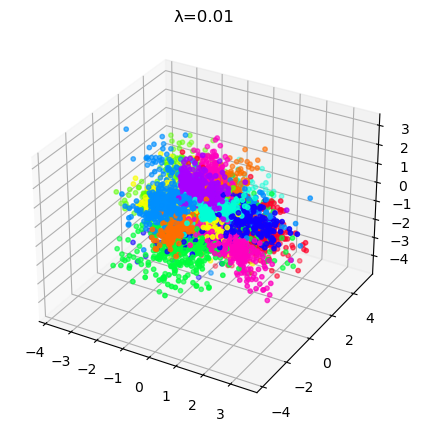

In [15]:
latent_3d_plot(encoder=ae.encoder, name='λ=0.01')

In [16]:
# lambda = 0.5, fixed batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.5
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

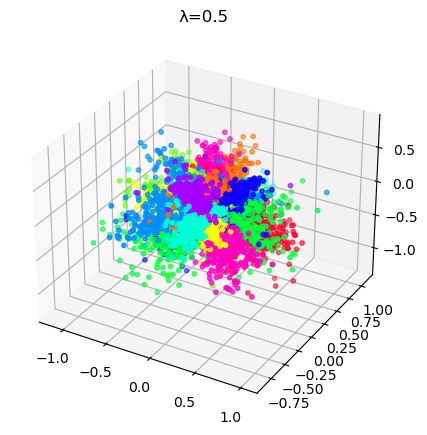

In [17]:
latent_3d_plot(encoder=ae.encoder, name='λ=0.5')

In [18]:
# lambda = 1, fixed batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 1
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

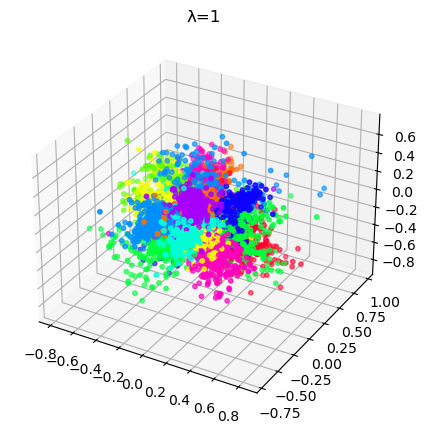

In [19]:
latent_3d_plot(encoder=ae.encoder, name='λ=1')

In [20]:
# lambda = 2, fixed batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 2
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

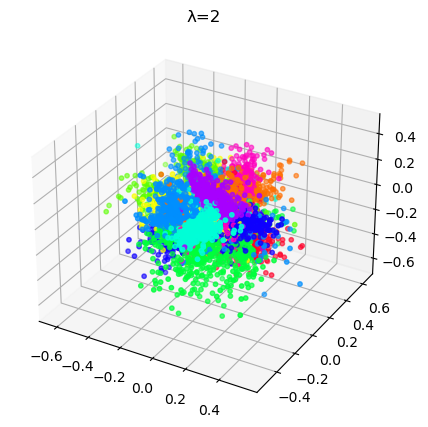

In [21]:
latent_3d_plot(encoder=ae.encoder, name='λ=2')

### Experiment with batch_size

Epoch 1/60 (time usage: 8.1949s):
Train_Loss: 0.637922
Epoch 2/60 (time usage: 7.9389s):
Train_Loss: 0.596295
Epoch 3/60 (time usage: 7.7593s):
Train_Loss: 0.582003
Epoch 4/60 (time usage: 7.8073s):
Train_Loss: 0.572317
Epoch 5/60 (time usage: 7.5811s):
Train_Loss: 0.565063
Epoch 6/60 (time usage: 7.6461s):
Train_Loss: 0.559140
Epoch 7/60 (time usage: 7.2421s):
Train_Loss: 0.554101
Epoch 8/60 (time usage: 7.4397s):
Train_Loss: 0.549847
Epoch 9/60 (time usage: 7.2649s):
Train_Loss: 0.546187
Epoch 10/60 (time usage: 7.2627s):
Train_Loss: 0.543098
Epoch 11/60 (time usage: 7.4402s):
Train_Loss: 0.540426
Epoch 12/60 (time usage: 7.7733s):
Train_Loss: 0.537689
Epoch 13/60 (time usage: 7.7661s):
Train_Loss: 0.535143
Epoch 14/60 (time usage: 7.8622s):
Train_Loss: 0.533311
Epoch 15/60 (time usage: 7.7873s):
Train_Loss: 0.531140
Epoch 16/60 (time usage: 7.9855s):
Train_Loss: 0.529414
Epoch 17/60 (time usage: 7.9187s):
Train_Loss: 0.527606
Epoch 18/60 (time usage: 8.0331s):
Train_Loss: 0.525886
E

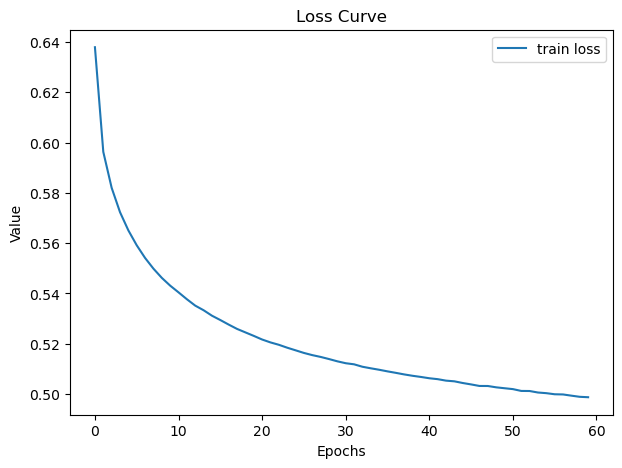

In [22]:
# fixed lambda = 0.1, batch_size = 100
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence)

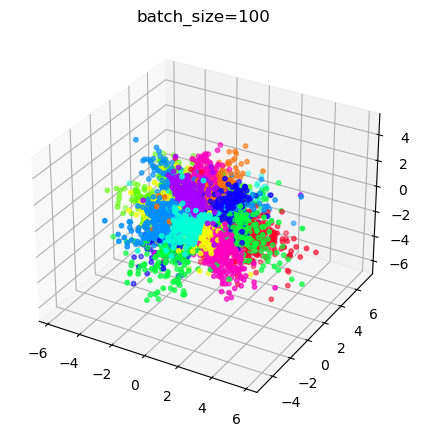

In [23]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=100')

In [24]:
# fixed lambda = 0.1, batch_size = 5
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 5

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

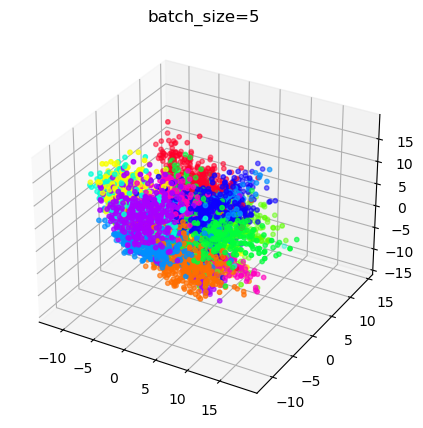

In [25]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=5')

In [26]:
# fixed lambda = 0.1, batch_size = 10
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 10

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

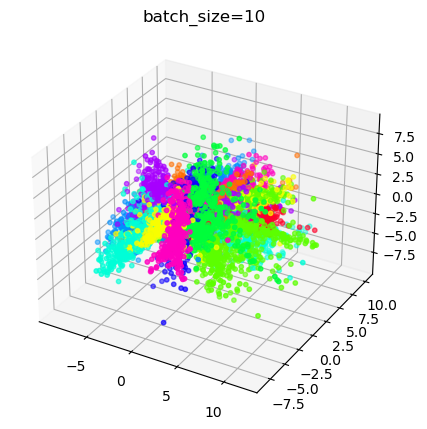

In [27]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=10')

In [28]:
# fixed lambda = 0.1, batch_size = 20
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 20

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

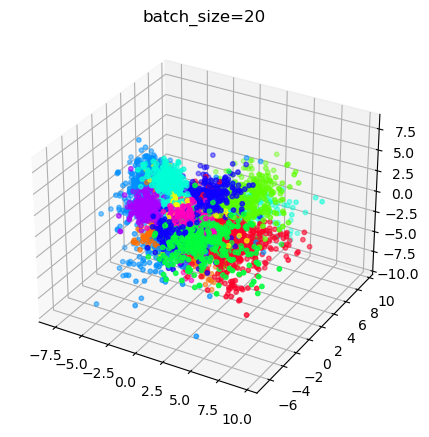

In [29]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=20')

In [30]:
# fixed lambda = 0.1, batch_size = 50
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 50

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

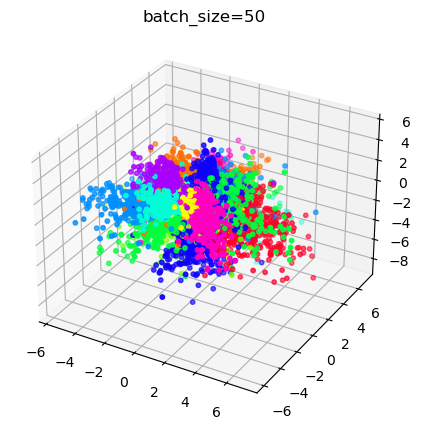

In [31]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=50')

In [32]:
# fixed lambda = 0.1, batch_size = 500
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 500

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

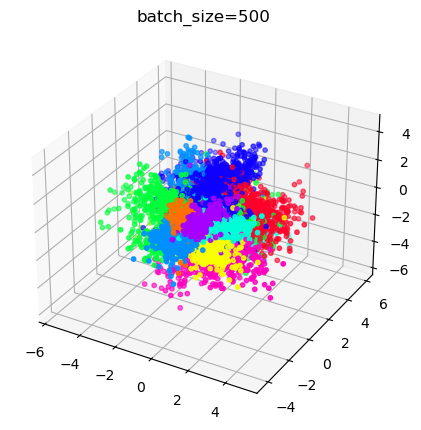

In [33]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=500')

In [34]:
# fixed lambda = 0.1, batch_size = 1000
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 3
epochs = 60
lamb = 0.1
batch_size = 1000

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=False,
                      visualization=False)

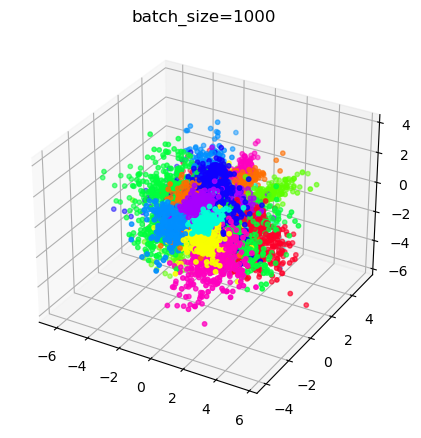

In [35]:
latent_3d_plot(encoder=ae.encoder, name='batch_size=1000')

We use λ = 0.1 and batch_size = 100 as optimal selection.

## Classifier

In [46]:
# Create the dataloader 
batch_size = 100 ### Same as the project 1
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          sampler=train_sampler) 

val_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        num_workers=2,
                        sampler=val_sampler)

test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset),
                         num_workers=2,
                         shuffle=True)

whole_train_loader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                num_workers=2)

Epoch 1/100 (time usage: 8.8189s):
Train_Loss: 0.380852
Epoch 2/100 (time usage: 7.3314s):
Train_Loss: 0.272965
Epoch 3/100 (time usage: 7.5581s):
Train_Loss: 0.246727
Epoch 4/100 (time usage: 8.0370s):
Train_Loss: 0.232102
Epoch 5/100 (time usage: 7.5581s):
Train_Loss: 0.222474
Epoch 6/100 (time usage: 7.7549s):
Train_Loss: 0.215453
Epoch 7/100 (time usage: 7.8218s):
Train_Loss: 0.209973
Epoch 8/100 (time usage: 7.9024s):
Train_Loss: 0.205558
Epoch 9/100 (time usage: 7.6975s):
Train_Loss: 0.201835
Epoch 10/100 (time usage: 7.6254s):
Train_Loss: 0.198659
Epoch 11/100 (time usage: 7.9304s):
Train_Loss: 0.195831
Epoch 12/100 (time usage: 7.7502s):
Train_Loss: 0.193339
Epoch 13/100 (time usage: 7.3971s):
Train_Loss: 0.191147
Epoch 14/100 (time usage: 7.4833s):
Train_Loss: 0.189146
Epoch 15/100 (time usage: 7.3157s):
Train_Loss: 0.187264
Epoch 16/100 (time usage: 7.3665s):
Train_Loss: 0.185569
Epoch 17/100 (time usage: 7.4612s):
Train_Loss: 0.184034
Epoch 18/100 (time usage: 7.6626s):
Trai

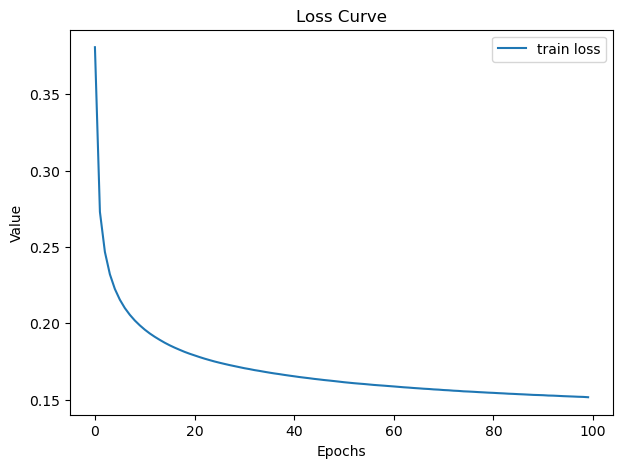

In [40]:
# Train the ae with bottle neck is 60:
# fixed lambda = 0.1, batch_size = 1000
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 60
epochs = 100
lamb = 0.1
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=True,
                      visualization=True)

In [53]:
# # save the model
# torch.save(ae.state_dict(), './models/ae_for_classifier_part2.pth')

In [41]:
# Design MLP for classification

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(60, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [93]:
# Define function for training classifier
# Training function for each epoch
def classifier_train_epoch(encoder, classifier, device, train_loader, criterion, optimizer):
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_step = len(train_loader)
    for idx, (img, target) in enumerate(train_loader):
        # Set to device
        img, target = img.to(device), target.to(device)
        # Forward pass
        bottleneck = encoder(img)
        output = classifier(bottleneck)
        loss = criterion(output, target)
        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    return train_loss/train_step, train_correct/len(train_loader.sampler)*100

# validation function for each epoch
def val_epoch(encoder, classifier, device, val_loader, criterion):
    classifier.eval()
    val_step = len(val_loader)
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        val_loss = 0.0
        val_correct = 0.0
        total = 0.0
        for idx, (img, target) in enumerate(val_loader):
            # Set to device
            img, target = img.to(device), target.to(device)
            # Forward pass
            bottleneck = encoder(img)
            output = classifier(bottleneck)
            # Update loss and accuracy
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            val_correct += (predicted == target).sum().item()
            val_loss += loss.item()
    return val_loss/val_step, 100.0 * val_correct / total

# Training function
def classifier_training(encoder, classifier, train_loader, val_loader, device, epochs, optimizer, criterion, early_stop=False, visualization=False, printer=True):
    encoder = encoder.to(device)
    classifier = classifier.to(device)
    # Disable gradient computation for encoder 
    for param in encoder.parameters():
        param.requires_grad = False
    train_lc, val_lc = [], []
    train_acc, val_acc = [], []
    best_acc = -float('inf')
    if printer:
        print('================================================================')
    for epoch in range(epochs):
        start = time.time()
        # Train in one epoch
        train_loss, train_correct = classifier_train_epoch(encoder, classifier, device, train_loader, criterion, optimizer)
        end = time.time()
        train_lc.append(train_loss)
        train_acc.append(train_correct)
        
        # Validation in one epoch
        if val_loader != None:
            val_loss, val_correct = val_epoch(encoder, classifier, device, val_loader, criterion)
            val_lc.append(val_loss)
            val_acc.append(val_correct)
            if val_correct > best_acc:
                best_acc = val_correct
                torch.save(classifier.state_dict(), './models/mlp_classifier_after_encoder_weights_part2.pth')
        
        if printer:
            print('Epoch {}/{} (time usage: {:.4f}s):'.format(epoch+1, epochs, end - start))
            if val_loader != None:
                print('Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss, train_correct))
                print('Val_Loss: {:.6f}, Val_Accuracy: {:.2f}%'.format(val_loss, val_correct))
            else:
                print('Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss, train_correct))
            print('================================================================')
    
    if visualization:
        plt.figure(figsize=(14, 5))
        plt.subplot(121)
        plt.plot(train_lc, label='train loss')
        if val_loader != None:
            plt.plot(val_lc, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(122)
        plt.plot(train_acc, label='train acc')
        if val_loader != None:
            plt.plot(val_acc, label='validation acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value / %')
        plt.legend()
    
    if not val_loader:
        return (train_lc, train_acc)
    return (train_lc, train_acc, val_lc, val_acc)

In [ ]:
# # Train classifier with validation
# # Define the hyperparameter
# lr = 0.0008
# epochs = 80

# # Define mapper, cost function and learing algorithm
# torch.manual_seed(8)
# encoder = ae.encoder
# classifier = MLPClassifier()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-05)

# # Training
# history = classifier_training(encoder,
#                               classifier,
#                               train_loader=train_loader, 
#                               val_loader=val_loader,
#                               device=device,
#                               epochs=epochs,
#                               optimizer=optimizer,
#                               criterion=criterion,
#                               visualization=True)

Epoch 1/60 (time usage: 7.6667s):
Loss: 0.326657, Accuracy: 90.81%
Val_Loss: 0.400175, Val_Accuracy: 87.92%
Epoch 2/60 (time usage: 7.4769s):
Loss: 0.121851, Accuracy: 96.45%
Val_Loss: 0.346490, Val_Accuracy: 89.84%
Epoch 3/60 (time usage: 7.7825s):
Loss: 0.070519, Accuracy: 98.18%
Val_Loss: 0.341298, Val_Accuracy: 90.23%
Epoch 4/60 (time usage: 7.4927s):
Loss: 0.041279, Accuracy: 99.03%
Val_Loss: 0.364933, Val_Accuracy: 90.24%
Epoch 5/60 (time usage: 7.6364s):
Loss: 0.026541, Accuracy: 99.42%
Val_Loss: 0.369283, Val_Accuracy: 90.76%
Epoch 6/60 (time usage: 7.5975s):
Loss: 0.023835, Accuracy: 99.36%
Val_Loss: 0.374361, Val_Accuracy: 91.08%
Epoch 7/60 (time usage: 7.4057s):
Loss: 0.024544, Accuracy: 99.24%
Val_Loss: 0.413891, Val_Accuracy: 90.70%
Epoch 8/60 (time usage: 7.5525s):
Loss: 0.017905, Accuracy: 99.50%
Val_Loss: 0.405531, Val_Accuracy: 91.50%
Epoch 9/60 (time usage: 7.5714s):
Loss: 0.012944, Accuracy: 99.64%
Val_Loss: 0.388953, Val_Accuracy: 91.76%
Epoch 10/60 (time usage: 7.3

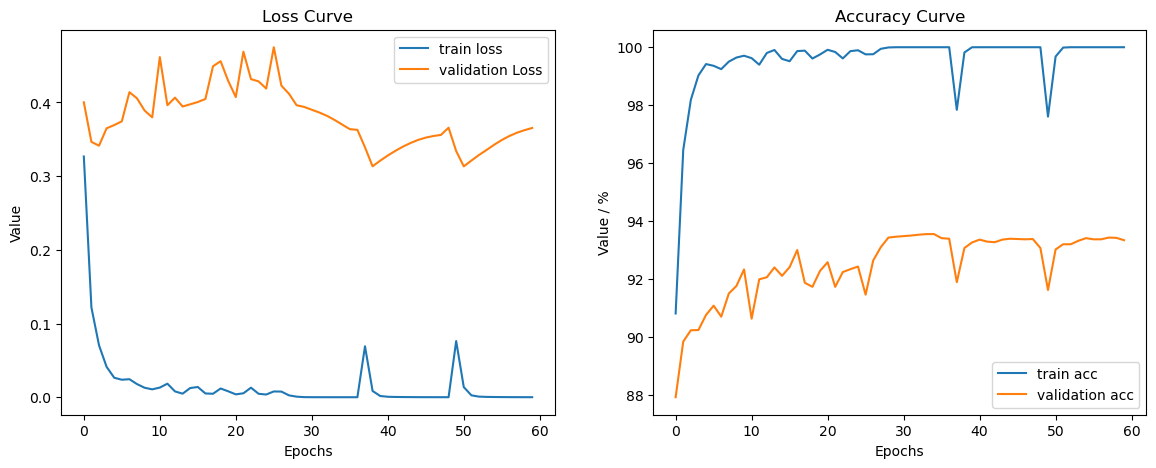

In [76]:
# Train classifier with whole training set
# Define the hyperparameter
lr = 0.0008
epochs = 60

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = ae.encoder
classifier = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = classifier_training(encoder,
                              classifier,
                              train_loader=whole_train_loader, 
                              val_loader=test_loader,
                              device=device,
                              epochs=epochs,
                              optimizer=optimizer,
                              criterion=criterion,
                              visualization=True)

In [79]:
class CombinedClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

classifier = MLPClassifier()
classifier.load_state_dict(torch.load('./models/mlp_classifier_after_encoder_weights_part2.pth'))
sae_mlp_classifier = CombinedClassifier(ae.encoder, classifier)

In [81]:
# save the model
torch.save(sae_mlp_classifier.state_dict(), './models/sae_mlp_classifier_weights_part2.pth')

In [82]:
# Load the classifier in project 2
ae_1 = Autoencoder(60)
mlp_classsifier = MLPClassifier()

classifier_part2 = CombinedClassifier(ae.encoder, mlp_classsifier)
classifier_part2.load_state_dict(torch.load('./models/sae_mlp_classifier_weights_part2.pth'))

<All keys matched successfully>

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define evaluation function for model
def eval_model(model, test_loader): 
    model = model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    test_probs = []
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
    print('\nACCURACY: {}'.format(accuracy_score(true_labels, predicted_labels)))
    print('----------------------------------')
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    


ACCURACY: 0.9355
----------------------------------


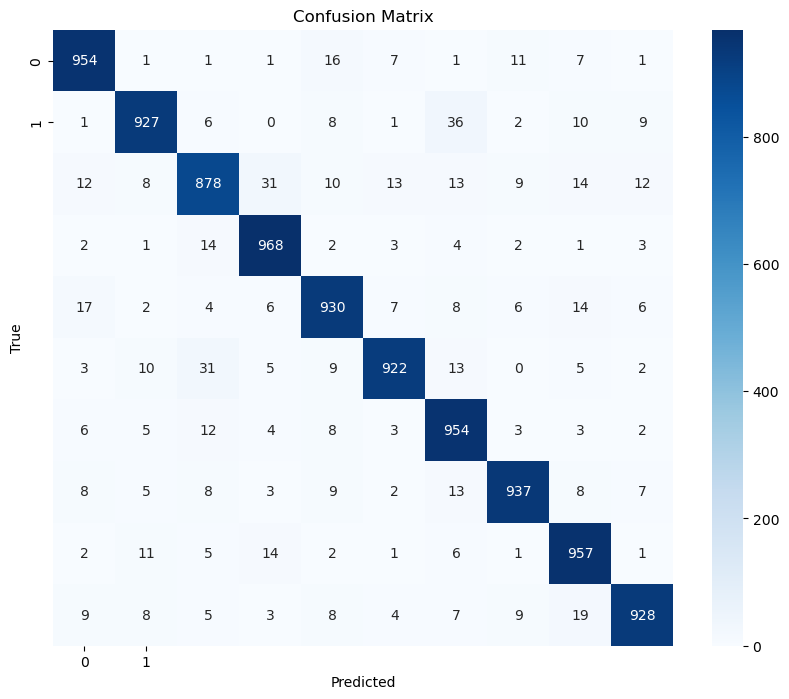

In [84]:
eval_model(classifier_part2, test_loader)

## Experiment with 10 bottleneck

Epoch 1/70 (time usage: 7.9203s):
Train_Loss: 0.495413
Epoch 2/70 (time usage: 7.4724s):
Train_Loss: 0.432012
Epoch 3/70 (time usage: 7.5603s):
Train_Loss: 0.412709
Epoch 4/70 (time usage: 7.4605s):
Train_Loss: 0.400953
Epoch 5/70 (time usage: 7.6986s):
Train_Loss: 0.392772
Epoch 6/70 (time usage: 7.9464s):
Train_Loss: 0.386525
Epoch 7/70 (time usage: 7.6926s):
Train_Loss: 0.381560
Epoch 8/70 (time usage: 7.6273s):
Train_Loss: 0.377388
Epoch 9/70 (time usage: 7.4570s):
Train_Loss: 0.373969
Epoch 10/70 (time usage: 7.7013s):
Train_Loss: 0.370968
Epoch 11/70 (time usage: 7.5366s):
Train_Loss: 0.368324
Epoch 12/70 (time usage: 7.5227s):
Train_Loss: 0.366005
Epoch 13/70 (time usage: 7.5424s):
Train_Loss: 0.363924
Epoch 14/70 (time usage: 7.4792s):
Train_Loss: 0.362094
Epoch 15/70 (time usage: 8.0379s):
Train_Loss: 0.360455
Epoch 16/70 (time usage: 7.7048s):
Train_Loss: 0.358956
Epoch 17/70 (time usage: 7.8228s):
Train_Loss: 0.357500
Epoch 18/70 (time usage: 7.6734s):
Train_Loss: 0.356213
E

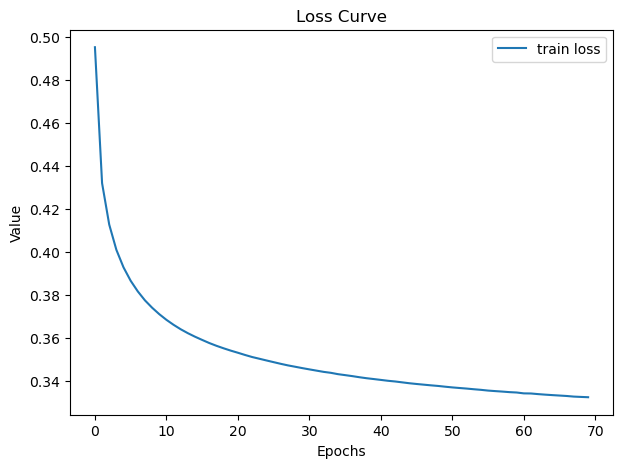

In [89]:
# Train the ae with bottle neck is 60:
# fixed lambda = 0.1, batch_size = 1000
# Hyperparameter setting
lr = 0.0008
bottleneck_size = 10
epochs = 70
lamb = 0.1
batch_size = 100

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
ae = Autoencoder(bottleneck_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = ae_training(ae=ae,
                      device=device,
                      train_dataset=train_dataset,
                      criterion=criterion,
                      optimizer=optimizer,
                      epochs=epochs,
                      lamb=lamb,
                      batch_size=batch_size,
                      divergence=cauchy_schwarz_divergence,
                      printer=True,
                      visualization=True)

In [90]:
# # save the model
# torch.save(ae.state_dict(), './models/ae_10_for_classifier_part2.pth')

In [91]:
# Design MLP for classification

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(10, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

Epoch 1/60 (time usage: 7.6017s):
Loss: 0.322031, Accuracy: 91.04%
Val_Loss: 0.582431, Val_Accuracy: 82.21%
Epoch 2/60 (time usage: 7.7058s):
Loss: 0.204337, Accuracy: 94.03%
Val_Loss: 0.555474, Val_Accuracy: 83.58%
Epoch 3/60 (time usage: 7.5338s):
Loss: 0.179587, Accuracy: 94.72%
Val_Loss: 0.541870, Val_Accuracy: 84.03%
Epoch 4/60 (time usage: 7.2600s):
Loss: 0.164375, Accuracy: 95.14%
Val_Loss: 0.543715, Val_Accuracy: 84.29%
Epoch 5/60 (time usage: 7.2899s):
Loss: 0.153268, Accuracy: 95.45%
Val_Loss: 0.541718, Val_Accuracy: 84.50%
Epoch 6/60 (time usage: 7.2628s):
Loss: 0.143669, Accuracy: 95.65%
Val_Loss: 0.541063, Val_Accuracy: 84.68%
Epoch 7/60 (time usage: 7.5135s):
Loss: 0.136113, Accuracy: 95.91%
Val_Loss: 0.537947, Val_Accuracy: 84.92%
Epoch 8/60 (time usage: 7.2399s):
Loss: 0.128917, Accuracy: 96.14%
Val_Loss: 0.542573, Val_Accuracy: 84.91%
Epoch 9/60 (time usage: 7.4401s):
Loss: 0.122933, Accuracy: 96.30%
Val_Loss: 0.543072, Val_Accuracy: 84.85%
Epoch 10/60 (time usage: 7.1

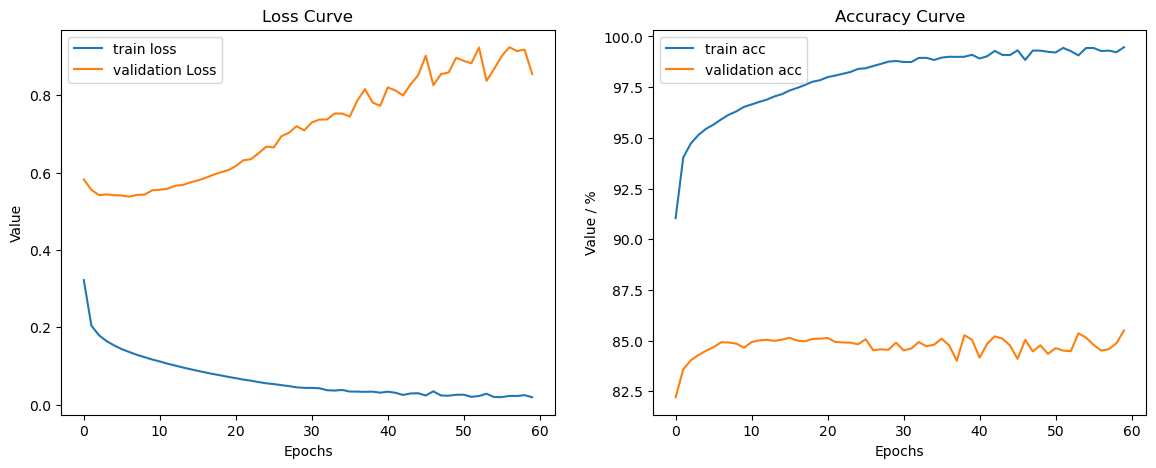

In [94]:
# Train classifier with whole training set
# Define the hyperparameter
lr = 0.0008
epochs = 60

# Define mapper, cost function and learing algorithm
torch.manual_seed(8)
encoder = ae.encoder
classifier = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-05)

# Training
history = classifier_training(encoder,
                              classifier,
                              train_loader=whole_train_loader, 
                              val_loader=test_loader,
                              device=device,
                              epochs=epochs,
                              optimizer=optimizer,
                              criterion=criterion,
                              visualization=True)

In [95]:
classifier = MLPClassifier()
classifier.load_state_dict(torch.load('./models/mlp_classifier_after_encoder_weights_part2.pth'))
sae_mlp_classifier = CombinedClassifier(ae.encoder, classifier)


ACCURACY: 0.88
----------------------------------


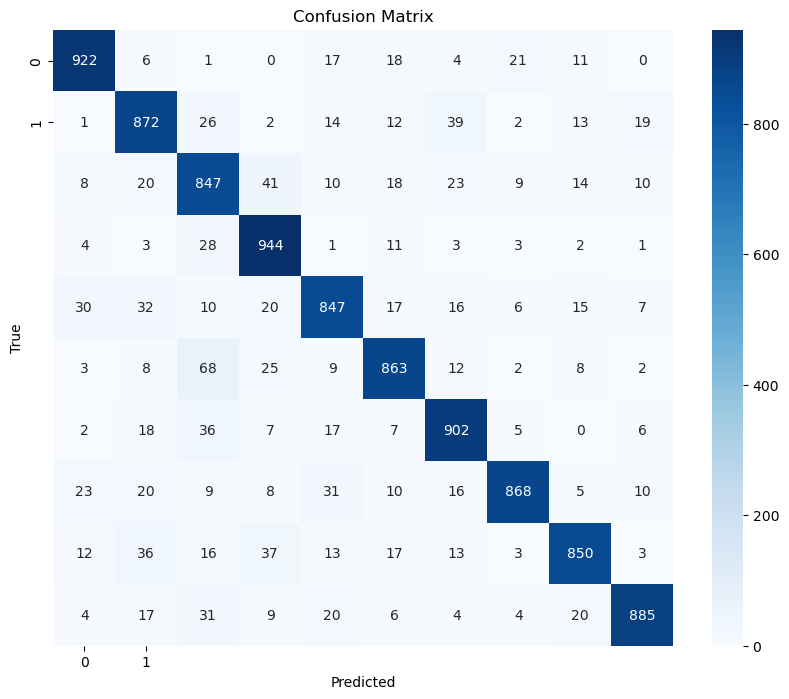

In [96]:
eval_model(sae_mlp_classifier, test_loader)

In [64]:
class CombinedClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(CombinedClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

encoder = ae.encoder
sae_mlp_classifier = CombinedClassifier(encoder, classifier)

In [65]:
# save the model
torch.save(sae_mlp_classifier.state_dict(), './models/sae_mlp_classifier_weights_part2.pth')

In [66]:
# Load the classifier in part 2
ae_1 = Autoencoder(60)
mlp_classsifier = MLPClassifier()
# ae_1.load_state_dict(torch.load('./models/ae_for_classifier_part2.pth'))
# mlp_classsifier.load_state_dict(torch.load('./models/mlp_classifier_after_encoder_weights_.pth'))
classifier_p2 = CombinedClassifier(ae_1.encoder, mlp_classsifier)
classifier_p2.load_state_dict(torch.load('./models/sae_mlp_classifier_weights_part2.pth'))

<All keys matched successfully>

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define evaluation function for model
def eval_model(model, test_loader): 
    model = model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    test_probs = []
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = torch.max(output.data, 1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
    print('\nACCURACY: {}'.format(accuracy_score(true_labels, predicted_labels)))
    print('----------------------------------')
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(2)), yticklabels=list(range(2)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


ACCURACY: 0.9241
----------------------------------


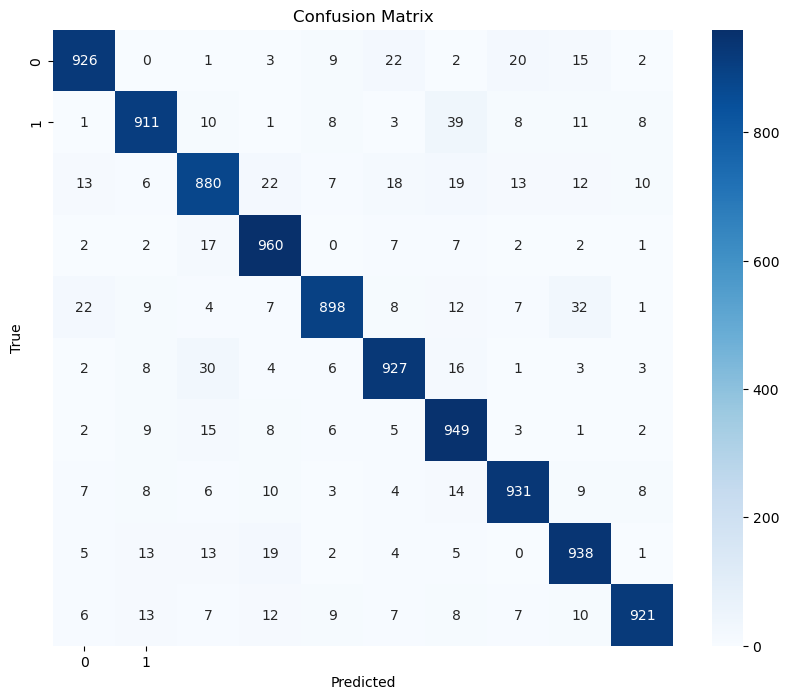

In [68]:
eval_model(classifier_p2, test_loader)